# ICON Stencil
This stencil is based on `model/atmosphere/dycore/src/icon4py/model/atmosphere/dycore/mo_velocity_advection_stencil_20.py`.
It is very simple and most faithfull implementation.

A reference `NumPy` implementation can be found in `model/atmosphere/dycore/tests/stencil_tests/test_mo_velocity_advection_stencil_20.py`.


In [1]:
import os, copy
ncpu=1
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={ncpu}"
os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false "
                           "intra_op_parallelism_threads=1")
os.environ['JAX_PLATFORMS'] = "cpu"

import numpy as np
import jax
import sys
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random

# This must be enabled when `make_jaxpr` is called, because otherwhise we get problems.
jax.config.update("jax_enable_x64", True)

import dace


In [2]:
from JaxprToSDFG import  JaxprToSDFG
t = JaxprToSDFG()

In [3]:
noITIR = False   # Do not use the GT4Py based translators or results
noSDFG = False    # Do not use the JAX -> SDFG based translators.

### Demo Input

### Grid Dimensions
Since we miss the GT4Py Dimension mechanism, we will make some tricks.
- `{K, Cell, Edge, Vertex}DimN` is the number of either Vertex, Cell, Edges or vertical levels.
- Valid indexes always life within the range `[0, N-1]` where `N` is the above entity.
- However, they do not denote at which position they are.



In [4]:
from icondims import SimpleGridData

### Offset Providers
Here we define the offset providors, i.e. the connectivity.
It is important that they have to be read in a certain way.

In [5]:


# As stated above, each edge is either adijacent to 1 cell (at the boundary) or 2 (in the inner part)
#  This table describes which cell are adijacent to a certain edge, in case it is undefined we have `-1`.  
edge_to_cell_table = np.array(SimpleGridData.e2c_table).astype(np.int32)

# We have a triangular grid, this means a cell is bounded by three edges.
#  In unstructured it could be, we have many geometrical forms, in this case
#  we would allocate the matrix such that it fits the largest one and fill up with `-1` if we do not need them.
cell_to_edge_table = np.array(SimpleGridData.c2e_table).astype(np.int32)




In [6]:
KDimN = 50     # Vertical levels
CellDimN = cell_to_edge_table.shape[0]   # How many cells we have
EdgeDimN = edge_to_cell_table.shape[0]
VertexDimN = SimpleGridData.v2c_table.shape[0]


# `E2C` is the offset map that transforms _edges_ to _cells_.
#   Since a edge is adijacent to at most two cells this dimension is 2 but at least 1.
E2CDimN = 2


In [7]:
# This is the level mask, the `+ 1` is taken from the test but it makes sense, at least a bit.
#  For `levelmask[Koff]` use `levelmask[:-1]`
#  and for `levelmask[Koff[+1]]` use `levelmask[1:]`.
levelmask = (np.random.rand(KDimN + 1) < 0.5).astype(np.bool_)

### Fields
These are the fields we are using as an inoput material

In [8]:
# Field defined on the edges of the grid and different in every hight level.
w_con_e = np.random.rand(EdgeDimN, KDimN).astype(np.float64)

# This is a field, which is the same for every height level.
#  It is defined for every edge but for each edge it has two values (thus `E2CDimN`) which is the result
#  of an cell to edge mapping.
c_lin_e = np.random.rand(EdgeDimN, E2CDimN).astype(np.float64)

# This is a field that defines for every cell in every height level one value.
z_w_con_c_full = np.random.rand(CellDimN, KDimN).astype(np.float64)

ddqz_z_full_e = np.random.rand(EdgeDimN, KDimN).astype(np.float64)

# This is the pseudoargument that we use to handle the return statement
_out = np.random.rand(EdgeDimN, KDimN).astype(np.float64)



cfl_w_limit = np.full((1), 4.0)
scalfac_exdiff = np.full((1), 6.0)
dtime = np.full((1), 2.0)

cfl_w_limit_, scalfac_exdiff_, dtime_ = cfl_w_limit[0], scalfac_exdiff[0], dtime[0]


# Implementation

### Python Implementation

In [9]:
# Note that this is only the first part of the stencil.
def TestStencil(c_lin_e: dace.float64[EdgeDimN, E2CDimN],
                w_con_e: dace.float64[EdgeDimN, KDimN],
                z_w_con_c_full: dace.float64[CellDimN, KDimN],
                levelmask: dace.bool_[KDimN+1],
                edge_to_cell_table: dace.int32[EdgeDimN, E2CDimN],
                
                ddqz_z_full_e: dace.float64,    # Ver 2
                cfl_w_limit: dace.float64,
                scalfac_exdiff: dace.float64,
                dtime: dace.float64,
):
    c_lin_e = jnp.expand_dims(c_lin_e, axis=-1)   # Adding a new dimensions of shape 1 at the end for propper broadcasting (taken from the test).
    #difcoef = jnp.zeros_like(w_con_e)
    
    levelmask_offset_0 = levelmask[:-1]   # This is `levelmask[Koff[0]]`, i.e. the normal field
    levelmask_offset_1 = levelmask[1:]    # This is `levelmask[Koff[1]]`, i.e. the field at the top.

    if(False):
        # This is more general but it requieres that a `scatter` operation is present.
        (EdgeDimN, E2CDimN, _) = c_lin_e.shape
        (CellDimN, KDimN)      = z_w_con_c_full.shape
        z_w_con_c_full_b = jnp.zeros((EdgeDimN, E2CDimN, KDimN))
        z_w_con_c_full_b = z_w_con_c_full_b.at[:, 0, :].set(z_w_con_c_full[edge_to_cell_table[:, 0], :]) 
        z_w_con_c_full_b = z_w_con_c_full_b.at[:, 1, :].set(z_w_con_c_full[edge_to_cell_table[:, 1], :])  # The `-1` in the `edge_to_cell_table` will be resolved as some bullshit values, that will be removed further down in the where.
        
    elif(False):
        z_w_0_ = z_w_con_c_full[edge_to_cell_table[:, 0], :]
        z_w_1_ = z_w_con_c_full[edge_to_cell_table[:, 1], :]
        z_w_con_c_full_0 = jnp.expand_dims(z_w_0_, axis=1)
        z_w_con_c_full_1 = jnp.expand_dims(z_w_1_, axis=1)
        z_w_con_c_full_b = jnp.concatenate((z_w_con_c_full_0, z_w_con_c_full_1), axis=1)

    elif(True):
        # These needs two briadcast dimenions
        z_w_con_c_full_b = z_w_con_c_full[edge_to_cell_table]
    #

    Z = jnp.where(
                jnp.expand_dims(edge_to_cell_table != -1, axis=-1), #(grid.connectivities[E2CDim] != -1)[:, :, np.newaxis],
                c_lin_e * z_w_con_c_full_b,    #z_w_con_c_full[grid.connectivities[E2CDim]],
                0,
    )
    if(False):
        # This is knoledge that we sum over the non iterated direction.
        Y = Z[:, 0, :] + Z[:, 1, :]
    else:
        Y = jnp.sum(Z, axis=1)

    w_con_e = jnp.where(levelmask_offset_0 | levelmask_offset_1, Y, w_con_e)
    difcoef = jnp.where(
        (levelmask_offset_0 | levelmask_offset_1) & (jnp.abs(w_con_e) > cfl_w_limit * ddqz_z_full_e),
        scalfac_exdiff
        * jnp.minimum(
            0.85 - cfl_w_limit * dtime,
            jnp.abs(w_con_e) * dtime / ddqz_z_full_e - cfl_w_limit * dtime,
        ),
        0,
    )
    return difcoef
#

In [10]:
with jax.disable_jit(disable=True):
    TestStencil_jaxpr = jax.make_jaxpr(TestStencil)(c_lin_e, w_con_e,
                                                    z_w_con_c_full,
                                                    levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0])
print(TestStencil_jaxpr)

{ lambda ; a:f64[27,2] b:f64[27,50] c:f64[18,50] d:bool[51] e:i32[27,2] f:f64[27,50]
    g:f64[] h:f64[] i:f64[]. let
    j:f64[27,2,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(27, 2, 1)
    ] a
    k:bool[50] = slice[limit_indices=(50,) start_indices=(0,) strides=None] d
    l:bool[50] = slice[limit_indices=(51,) start_indices=(1,) strides=None] d
    m:bool[27,2] = lt e 0
    n:i32[27,2] = add e 18
    o:i32[27,2] = select_n m e n
    p:i32[27,2,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(27, 2, 1)
    ] o
    q:f64[27,2,50] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(2,), collapsed_slice_dims=(0,), start_index_map=(0,))
      fill_value=None
      indices_are_sorted=False
      mode=GatherScatterMode.PROMISE_IN_BOUNDS
      slice_sizes=(1, 50)
      unique_indices=False
    ] c p
    r:bool[27,2] = ne e -1
    s:bool[27,2,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(27, 2, 1)
    ]

In [11]:
resExp = TestStencil(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0])

if(not noSDFG):
    TestStencil_sdfg = t(TestStencil_jaxpr, simplify=True, auto_opt=5, ret_by_arg=True)

    TestStencil_sdfg(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0], _out)
    resDC = _out.copy()
    assert np.allclose(resExp, resDC)
#

In [12]:
if(True):
    pass #TestStencil_sdfg.view()
else:
    TestStencil_sdfg.save("./SDFG_of_stencil.json")


### GT4Py Implementation

In [13]:
import gt4py
from gt4py.next.common import GridType
from gt4py.next.ffront.decorator import field_operator, program
from gt4py.next.ffront.fbuiltins import (  # noqa: A004 # import gt4py builtin
    Field,
    abs,
    broadcast,
    int32,
    minimum,
    neighbor_sum,
    where,
)

from icondims import (
    E2C,
    E2C2EO,
    E2V,
    CellDim,
    E2C2EODim,
    E2CDim,
    EdgeDim,
    KDim,
    Koff,
    VertexDim,
)

E2C_offset_provider = gt4py.next.NeighborTableOffsetProvider(edge_to_cell_table, EdgeDim, CellDim, 2)


@field_operator
def _mo_velocity_advection_stencil_20(
    levelmask: Field[[KDim], bool],
    c_lin_e: Field[[EdgeDim, E2CDim], float],
    z_w_con_c_full: Field[[CellDim, KDim], float],
    
    ddqz_z_full_e: Field[[EdgeDim, KDim], float],
    cfl_w_limit: float,
    scalfac_exdiff: float,
    dtime: float,
) -> Field[[EdgeDim, KDim], float]:
    w_con_e = broadcast(0.0, (EdgeDim, KDim))
    difcoef = broadcast(0.0, (EdgeDim, KDim))
    w_con_e = where(
        levelmask | levelmask(Koff[1]),
        neighbor_sum(c_lin_e * z_w_con_c_full(E2C), axis=E2CDim),
        w_con_e,
    )

    difcoef = where(
        (levelmask | levelmask(Koff[1])) & (abs(w_con_e) > cfl_w_limit * ddqz_z_full_e),
        scalfac_exdiff
        * minimum(
            0.85 - cfl_w_limit * dtime,
            abs(w_con_e) * dtime / ddqz_z_full_e - cfl_w_limit * dtime,
        ),
        difcoef,
    )
    
    return difcoef
#


@program(grid_type=GridType.UNSTRUCTURED)
def mo_velocity_advection_stencil_20(
    levelmask: Field[[KDim], bool],
    c_lin_e: Field[[EdgeDim, E2CDim], float],
    z_w_con_c_full: Field[[CellDim, KDim], float],

    ddqz_z_full_e: Field[[EdgeDim, KDim], float],
    cfl_w_limit: float,
    scalfac_exdiff: float,
    dtime: float,
    
    _ret_: Field[[EdgeDim, KDim], float],
    horizontal_start: int32,
    horizontal_end: int32,
    vertical_start: int32,
    vertical_end: int32,
):
    _mo_velocity_advection_stencil_20(
        levelmask,
        c_lin_e,
        z_w_con_c_full,
        ddqz_z_full_e, cfl_w_limit, scalfac_exdiff, dtime,
        out=_ret_,
        domain={
            EdgeDim: (horizontal_start, horizontal_end),
            KDim: (vertical_start, vertical_end),
        },
    )

In [14]:
from gt4py.next.program_processors.runners.dace_iterator import run_dace_iterator

levelmask_F = gt4py.next.as_field([KDim], levelmask)
c_lin_e_F = gt4py.next.as_field([EdgeDim, E2CDim], c_lin_e)
z_w_con_c_full_F = gt4py.next.as_field([CellDim, KDim], z_w_con_c_full)

ddqz_z_full_e_F = gt4py.next.as_field([EdgeDim, KDim], ddqz_z_full_e)

_ret_ = gt4py.next.as_field([EdgeDim, KDim], np.zeros((EdgeDimN, KDimN)))


In [15]:
if(not noITIR):
    TestStencil_itir_sdfg, TestStencil_itir_sdfg_args = run_dace_iterator(
        mo_velocity_advection_stencil_20.itir,
        
        levelmask_F, c_lin_e_F, z_w_con_c_full_F,
    
        ddqz_z_full_e_F, cfl_w_limit[0], scalfac_exdiff[0], dtime[0],

        _ret_,
        0, EdgeDimN, 0, KDimN,
    
        return_sdfg_args=True, run_sdfg=True,
        offset_provider={'E2C': E2C_offset_provider, "Koff": KDim}
    )

    # For some reason this test fails!
    #assert np.allclose(TestStencil_itir_sdfg_args['_ret_'], resExp)
#

## "Performance" / Runtime

In [16]:
import timeit
repeat, number = 3000, 50

_build_type = "Release"
# removing  -ffast-math from DaCe default compiler args in order to support isfinite/isinf/isnan built-ins
_cpu_args = dace.config.Config.get("compiler", "cpu", "args").replace('-ffast-math', '') + ' -fopenmp'


In [17]:
TestStencil_jax = jax.jit(TestStencil)

In [18]:
with dace.config.temporary_config():
    dace.config.Config.set("compiler", "build_type", value=_build_type)
    if(len(_cpu_args) > 0):
        dace.config.Config.set("compiler", "cpu", "args", value=_cpu_args)
    TestStencil_itir_prog = None if noITIR else TestStencil_itir_sdfg.compile()
    TestStencil_prog = None if noSDFG else TestStencil_sdfg.compile()


In [19]:
# Now to make that they are all loded, call them once
if(not noITIR):
    with dace.config.temporary_config():
        dace.Config.set('compiler', 'allow_view_arguments', value=True)
        _ = TestStencil_itir_prog(**TestStencil_itir_sdfg_args)

In [20]:
if(not noSDFG):
    pass
    _ = TestStencil_prog(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit_, scalfac_exdiff_, dtime_, _out=_out)

In [21]:
_ = TestStencil_jax(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0])

In [22]:
#%timeit TestStencil_itir_prog(**TestStencil_itir_sdfg_args_)
if(not noITIR):
    def TestStencil_itir_prog_TI():
        TestStencil_itir_prog._fast_call(*TestStencil_itir_prog._lastargs)
    #
    with dace.config.temporary_config():
        dace.Config.set('compiler', 'allow_view_arguments', value=True)
        t_ = timeit.Timer(TestStencil_itir_prog_TI)
        r = np.array(t_.repeat(repeat, number))
    print(f"Run the function {number} times inside a loop and repeated the loop {repeat} times:\n- min: {r.min()}s\n- max: {r.max()}s\n- mean: {r.mean()}s\n- std: {r.std()}s")


Run the function 50 times inside a loop and repeated the loop 3000 times:
- min: 0.0004265649995431886s
- max: 0.014048801000171807s
- mean: 0.000448331784342372s
- std: 0.00029975028820831073s


In [23]:
#%timeit TestStencil_prog(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0])
if(not noSDFG):
    def TestStencil_prog_TI():
        TestStencil_prog._fast_call(*TestStencil_prog._lastargs)
    #

    t_ = timeit.Timer(TestStencil_prog_TI)
    r = np.array(t_.repeat(repeat, number))
    print(f"Run the function {number} times inside a loop and repeated the loop {repeat} times:\n- min: {r.min()}s\n- max: {r.max()}s\n- mean: {r.mean()}s\n- std: {r.std()}s")


Run the function 50 times inside a loop and repeated the loop 3000 times:
- min: 0.00055763799991837s
- max: 0.001391368000440707s
- mean: 0.0005661741293351951s
- std: 1.6950233222036276e-05s


In [24]:
#%timeit TestStencil_jax(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0])
_JAX_ARGS = [c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0]]
def TestStencil_jax_TI():
    TestStencil_jax(*_JAX_ARGS)
#

t_ = timeit.Timer(TestStencil_jax_TI)
r = np.array(t_.repeat(repeat, number))

print(f"Run the function {number} times inside a loop and repeated the loop {repeat} times:\n- min: {r.min()}s\n- max: {r.max()}s\n- mean: {r.mean()}s\n- std: {r.std()}s")


Run the function 50 times inside a loop and repeated the loop 3000 times:
- min: 0.0005914479997954913s
- max: 0.00142173400035972s
- mean: 0.0006759142110113317s
- std: 4.1059958531210955e-05s


In [25]:
resTime_sdfg = []
resTime_jax  = []
resTime_itir = []
KDimNs       = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900]

for KDimN_ in KDimNs:
    print(f"Start with KDimN = {KDimN_}", flush=True)
    w_con_e = np.random.rand(EdgeDimN, KDimN_).astype(np.float64)
    z_w_con_c_full = np.random.rand(CellDimN, KDimN_).astype(np.float64)
    ddqz_z_full_e = np.random.rand(EdgeDimN, KDimN_).astype(np.float64)
    levelmask = (np.random.rand(KDimN_ + 1) < 0.5).astype(np.bool_)
    _out = np.random.rand(EdgeDimN, KDimN_).astype(np.float64)   # This is the argument for returning the result in the `JAX -> SDFG` Translation

    # Generating JAX Source
    with jax.disable_jit(disable=True):
        TestStencil_jaxpr = jax.make_jaxpr(TestStencil)(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0])
    #

    # Generating the ITIR Based translation
    if(not noITIR):
        levelmask_F = gt4py.next.as_field([KDim], levelmask)
        c_lin_e_F = gt4py.next.as_field([EdgeDim, E2CDim], c_lin_e)
        z_w_con_c_full_F = gt4py.next.as_field([CellDim, KDim], z_w_con_c_full)
        ddqz_z_full_e_F = gt4py.next.as_field([EdgeDim, KDim], ddqz_z_full_e)
        _ret_ = gt4py.next.as_field([EdgeDim, KDim], np.zeros_like(ddqz_z_full_e))
        TestStencil_itir_sdfg, TestStencil_itir_sdfg_args = run_dace_iterator(
                mo_velocity_advection_stencil_20.itir, levelmask_F, c_lin_e_F, z_w_con_c_full_F,ddqz_z_full_e_F, cfl_w_limit_, scalfac_exdiff_, dtime_,
                _ret_, 0, EdgeDimN, 0, KDimN_, return_sdfg_args=True, run_sdfg=False,    offset_provider={'E2C':E2C_offset_provider, "Koff": KDim})
        #
    #

    # Translating from JAX to SDFG
    if(not noSDFG):
        TestStencil_sdfg = t(TestStencil_jaxpr, simplify=True, auto_opt=5, ret_by_arg=True)

    # Create the computations
    with dace.config.temporary_config():
        dace.config.Config.set("compiler", "build_type", value=_build_type)
        if(len(_cpu_args) > 0):
            dace.config.Config.set("compiler", "cpu", "args", value=_cpu_args)
        if(not noSDFG):
            TestStencil_prog = TestStencil_sdfg.compile()
            # Ensure that everything is initialized
            _ = TestStencil_prog(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0], _out=_out)
        if(not noITIR):
            TestStencil_itir_prog = TestStencil_itir_sdfg.compile()
            # Ensure that everything is initialized
            with dace.config.temporary_config():
                dace.Config.set('compiler', 'allow_view_arguments', value=True)
                _ = TestStencil_itir_prog(**TestStencil_itir_sdfg_args)
    #

    if(not noITIR):
        #TestStencil_itir_prog_TI = lambda: TestStencil_itir_prog(**TestStencil_itir_sdfg_args)
        TestStencil_itir_prog_TI = lambda: TestStencil_itir_prog._fast_call(*TestStencil_itir_prog._lastargs)
    #
    if(not noSDFG):
        #TestStencil_prog_TI = lambda: TestStencil_prog(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit[0], scalfac_exdiff[0], dtime[0], _out=_out)
        TestStencil_prog_TI = lambda: TestStencil_prog._fast_call(*TestStencil_prog._lastargs)
    #
    TestStencil_jax_TI = lambda: TestStencil_jax(c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit_, scalfac_exdiff_, dtime_)
    TestStencil_jax_TI()    # Call it once to ensure that it is present
    
    # Test ITIR Translation
    if(not noITIR):
        with dace.config.temporary_config():
            dace.Config.set('compiler', 'allow_view_arguments', value=True)
            t_ = timeit.Timer(TestStencil_itir_prog_TI)
            r = np.array(t_.repeat(repeat, number))
    else:
        r = np.zeros(repeat)
    resTime_itir.append(r)

    # Test SDFG
    if(not noSDFG):
        t_ = timeit.Timer(TestStencil_prog_TI)
        r = np.array(t_.repeat(repeat, number))
    else:
        r = np.zeros(repeat)
    resTime_sdfg.append(r)

    # Test JAX
    t_ = timeit.Timer(TestStencil_jax_TI)
    r = np.array(t_.repeat(repeat, number))
    resTime_jax.append(r)
#


Start with KDimN = 50


/home/quint_essent/git/1_CSCS/jax_demo/dace/sdfg/sdfg.py:2185: UserWarning: SDFG "mo_velocity_advection_stencil_20" is already loaded by another object, recompiling under a different name.
  warnings.warn('SDFG "%s" is already loaded by another object, '


Start with KDimN = 100
Start with KDimN = 200
Start with KDimN = 300
Start with KDimN = 400
Start with KDimN = 500
Start with KDimN = 600
Start with KDimN = 700
Start with KDimN = 800
Start with KDimN = 900


In [26]:
resTime_sdfg_min = np.array([r.min()  for r in resTime_sdfg])
resTime_jax_min = np.array([r.min()  for r in resTime_jax])
resTime_itir_min = np.array([r.min()  for r in resTime_itir])

resTime_sdfg_mean = np.array([r.mean()  for r in resTime_sdfg])
resTime_jax_mean = np.array([r.mean()  for r in resTime_jax])
resTime_itir_mean = np.array([r.mean()  for r in resTime_itir])

resTime_sdfg_std = np.array([r.std()  for r in resTime_sdfg])
resTime_jax_std = np.array([r.std()  for r in resTime_jax])
resTime_itir_std = np.array([r.std()  for r in resTime_itir])


In [27]:
import matplotlib as mpl
from matplotlib import pyplot as plt

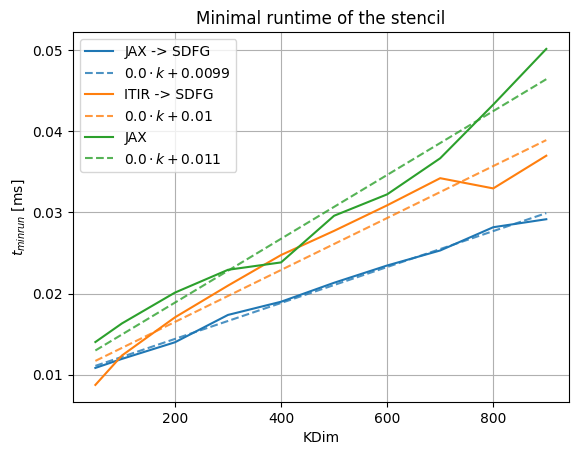

In [30]:
X = np.vstack([KDimNs, np.ones_like(KDimNs)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'ITIR -> SDFG': resTime_itir_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(KDimNs, Time * 1000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = np.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * np.array(KDimNs) + b
    plt.plot(
        KDimNs, Times_ * 1000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e3*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )
#


plt.legend()
plt.xlabel('KDim')
plt.ylabel('$t_{min run}$ [ms]')
plt.grid(visible=True)
#plt.yscale('log')

plt.title("Minimal runtime of the stencil")

plt.show()


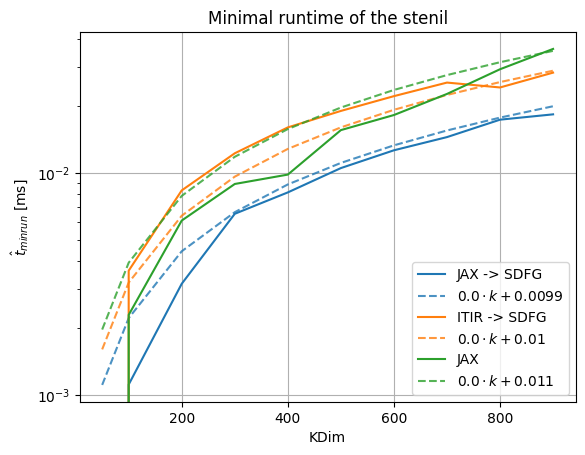

In [29]:
X = np.vstack([KDimNs, np.ones_like(KDimNs)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'ITIR -> SDFG': resTime_itir_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(KDimNs, (Time - Time[0]) * 1000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = np.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * np.array(KDimNs)
    plt.plot(
        KDimNs, Times_ * 1000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e3*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )

#


plt.legend()
plt.xlabel('KDim')
plt.ylabel('$\\hat{t}_{min run}$ [ms]')
plt.grid(visible=True)
plt.yscale('log')

plt.title("Minimal runtime of the stenil")

plt.show()
